In [1]:
# Dependencies
%matplotlib inline

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from math import sqrt

In [2]:
# Function to Remove Outliers 
def remove_outlier(df, col):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1
  lower_bound  = q1 - (1.5  * iqr)
  upper_bound = q3 + (1.5 * iqr)
  out_df = df.loc[(df[col] > lower_bound) & (df[col] < upper_bound)]
  return out_df



# Read and Process Training Set

In [3]:
# Read Housing Price Training Data
training_df = pd.read_csv("MLResources/realestate_all_train.csv")

# Remove outliers - Training Data
training_df = remove_outlier(training_df,"Price")
training_df.reset_index(drop=True, inplace=True)

training_df.head()
training_df.count()

County    1104
State     1104
Year      1104
Price     1104
dtype: int64

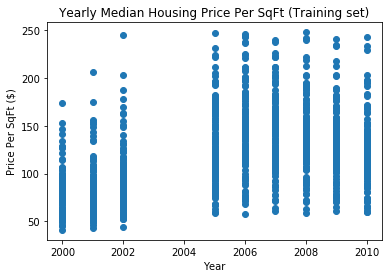

In [4]:
# Plot Training Data - YoY Price of All Counties 
plt.plot(training_df['Year'], training_df['Price'],'o')
plt.title('Yearly Median Housing Price Per SqFt (Training set)')
plt.xlabel('Year')
plt.ylabel('Price Per SqFt ($)')
plt.show()

# Handling Missing Data

In [5]:
# Handle missing data
missing_df = training_df.loc[training_df['Year'].isin(['2003','2004'])]
missing_df.head()  

,County,State,Year,Price


In [6]:
# plt.hist(training_df['Price'], 2004)
# plt.show()

In [7]:
# Backfill missing data for 2003 and 2004 from a median of 2002 and 2005 
backfill_2002_df = training_df.loc[training_df['Year'].isin(['2002'])]
backfill_2005_df = training_df.loc[training_df['Year'].isin(['2005'])]
backfill_2002_df = backfill_2002_df.dropna()
backfill_2005_df = backfill_2005_df.dropna()
backfill_2002_df.count()
backfill_2005_df.count()

County    120
State     120
Year      120
Price     120
dtype: int64

In [8]:
backfill_df = backfill_2002_df.merge(backfill_2005_df, on=['County','State'], how='inner')
backfill_df.head()

,County,State,Year_x,Price_x,Year_y,Price_y
0,King County,WA,2002,154.750000,2005,202.750000
1,Prince Georges County,MD,2002,108.583333,2005,194.166667
2,Baltimore County,MD,2002,99.250000,2005,163.666667
3,Pierce County,WA,2002,106.166667,2005,148.916667
4,Snohomish County,WA,2002,140.083333,2005,179.083333


In [9]:
backfill_df['Diff_Price'] = backfill_df['Price_y'] - backfill_df['Price_x']
backfill_df['2003_Price'] = backfill_df['Diff_Price']/3 + backfill_df['Price_x']
backfill_df['2004_Price'] = backfill_df['Price_y'] - backfill_df['Diff_Price']/3 
backfill_df.head()

,County,State,Year_x,Price_x,Year_y,Price_y,Diff_Price,2003_Price,2004_Price
0,King County,WA,2002,154.750000,2005,202.750000,48.000000,170.750000,186.750000
1,Prince Georges County,MD,2002,108.583333,2005,194.166667,85.583333,137.111111,165.638889
2,Baltimore County,MD,2002,99.250000,2005,163.666667,64.416667,120.722222,142.194444
3,Pierce County,WA,2002,106.166667,2005,148.916667,42.750000,120.416667,134.666667
4,Snohomish County,WA,2002,140.083333,2005,179.083333,39.000000,153.083333,166.083333


In [10]:
backfill_2003 = backfill_df.loc[:, ['County','State','Year','2003_Price']]
backfill_2003['Year'] = 2003
backfill_2003 = backfill_2003.rename(columns = {'2003_Price': 'Price'})
# backfill_2003.head()

/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [11]:
backfill_2004 = backfill_df.loc[:, ['County','State','Year','2004_Price']]
backfill_2004['Year'] = 2004
backfill_2004 = backfill_2004.rename(columns = {'2004_Price': 'Price'})
# backfill_2004.head()

In [12]:
training_df = training_df.append(backfill_2003, ignore_index=True)
training_df = training_df.append(backfill_2004, ignore_index=True)
training_df.head()

,County,State,Year,Price
0,King County,WA,2000,141.166667
1,Fairfax County,VA,2000,134.000000
2,Montgomery County,MD,2000,126.916667
3,Prince Georges County,MD,2000,91.833333
4,Baltimore County,MD,2000,86.750000


In [ ]:
print(training_df.loc[training_df['Price'].isin(['NaN'])].count())

In [ ]:
training_dfdum = training_df.dropna()
training_dfdum.head()
training_dfdum.count()

In [ ]:
print(training_dfdum.loc[training_dfdum['Price'].isin(['NaN'])])

# Plot Training Set 

In [ ]:
# Plot Training Data After Handling Missig Data - YoY Price of All Counties 
plt.plot(training_dfdum['Year'], training_dfdum['Price'],'o')
plt.title('Yearly Median Housing Price Per SqFt (Training set)')
plt.xlabel('Year')
plt.ylabel('Price Per SqFt ($)')
plt.show()

# Read and Process Test Set 

In [ ]:
# Read Housing Price Testing Data
testing_df = pd.read_csv("MLResources/realestate_all_test.csv")

# Remove outliers - Testing Data
testing_df = remove_outlier(testing_df,"Price")
testing_df.reset_index(drop=True, inplace=True)


# Filter data into Testing set for only matching counties in the Training set
testing_df = testing_df.loc[testing_df['County'].isin(training_df['County'])]
testing_df.head()
testing_df.count()


In [ ]:
testing_dfdum = testing_df.dropna()
testing_dfdum.head()
# testing_dfdum.count()

# Plot Testing Set

In [ ]:
# Plot Testing Data - YoY Price of All Counties 
plt.plot(testing_df['Year'], testing_df['Price'],'o')
plt.title('Yearly Median Housing Price Per SqFt (Testing set)')
plt.xlabel('Year')
plt.ylabel('Price Per SqFt ($)')
plt.show()

# Shaping Training Set

In [ ]:
# Encode Categorical Features - County and State
cat_features = ['County','State']
num_features = ['Price','Year']

categories = cat_features[0:len(cat_features)]

for category in categories:
    series = training_dfdum[category]
    dummies = pd.get_dummies(series, prefix=category)
    training_dfdum = pd.concat([training_dfdum, dummies], axis=1)
    
print(training_dfdum.columns)
training_dfdum.head()
training_dfdum.count()
training_dfdum.shape

In [ ]:
# Feature Scaling (remove features not encoded) 
removefeats= ["County","State","Price"]

# standardScalerX = StandardScaler()
# x = standardScalerX.fit_transform(training_dfdum.drop(removefeats, axis=1))
# x

X_train = training_dfdum.drop(removefeats, axis=1)
y_train = training_dfdum['Price']


# Shaping Testing Set

In [ ]:
# Encode Categorical Features - County and State
# cat_features = ['County','State']
# num_features = ['Price','Year']

# categories = cat_features[0:len(cat_features)]

for category in categories:
    series = testing_dfdum[category]
    dummies = pd.get_dummies(series, prefix=category)
    testing_dfdum = pd.concat([testing_dfdum, dummies], axis=1)
    
print(testing_dfdum.columns)
testing_dfdum.head()
testing_dfdum.count()
testing_dfdum.shape

In [ ]:
# Get mismatch columns in the training set and testing set
print(set(training_dfdum.columns) - set(testing_dfdum.columns) )
print(set(testing_dfdum.columns) - set(training_dfdum.columns) )

In [ ]:
# Get missing columns in the training test
missing_cols = set( training_dfdum.columns ) - set( testing_dfdum.columns )

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    testing_dfdum[c] = 0
    
# Ensure the order of column in the test set is in the same order than in train set
testing_dfdum = testing_dfdum[training_dfdum.columns]
testing_dfdum.reset_index(drop=True, inplace=True)
testing_dfdum.head()


# Get missing columns in the training set
mismatch_cols = set(testing_dfdum.columns) - set(training_dfdum.columns)

# Drop columns from the testing set
for c in mismatch_cols:
#     testing_dfdum = testing_dfdum.loc[testing_dfdum[c] == 0]
    testing_dfdum = testing_dfdum.drop([c], axis=1).reset_index(drop=True, inplace=True)
    
# Ensure the order of column in the test set is in the same order as in train set
testing_dfdum = testing_dfdum[training_dfdum.columns]
testing_dfdum.count()


In [ ]:
# Find orphan Prices
testing_dforphan = testing_dfdum.loc[testing_dfdum['Price'].isin(['NaN'])]
testing_dforphan.head()

In [ ]:
# Remove features not encoded
removefeats= ["County","State","Price"]

X_test = testing_dfdum.drop(removefeats, axis=1)
y_test = testing_dfdum['Price']


# Shapes of Training and Testing Datasets

In [ ]:
# Shapes - Training and Testing Datasets
print ("Train data: \n")
print ("Number of columns: " + str (training_df.shape[1]))
print ("number of rows: " + str (training_df.shape[0]))

print('\nTest data: \n')
print ("number of columns:" + str (testing_df.shape[1]))
print ("Number of columns:" +  str (testing_df.shape[0]))

# Model Fit and Evaluate

In [ ]:
# Create & Fit Linear Regression Model 

regr = linear_model.LinearRegression()

lr_model = regr.fit(X_train, y_train)


In [ ]:
# Predict on Training Data
y_train_predict = lr_model.predict(X_train)
print(f"True output: {y_train[0]}")
print(f"Predicted output: {y_train_predict[0]}")
print(f"Prediction Error: {y_train_predict[0]-y_train[0]}")

In [ ]:
print(f"True output: {y_train[2]}")
print(f"Predicted output: {y_train_predict[2]}")
print(f"Prediction Error: {y_train_predict[2]-y_train[2]}")

In [ ]:
# Plot Residuals - Training Data
plt.scatter(y_train_predict, y_train_predict - y_train)
plt.hlines(y=0, xmin=y_train_predict.min(), xmax=y_train_predict.max())
plt.title('Residuals (Training set)')
plt.xlabel('Predict')
plt.ylabel('Predict Error (Diff of Predict - Actual)')
plt.show()

In [ ]:
# # Plot Predictions of Testing Data - YoY Price of All Counties 
# plt.plot(X_train['Year'], y_train_predict, 'o')
# plt.title('Prediction on Training Data - Yearly Median Housing Price Per SqFt')
# plt.xlabel('Year')
# plt.ylabel('Price Per SqFt ($)')
# plt.show()

In [ ]:
# # Score
# score = lr_model.score(X_train, y_train)
# print(f"Score: {score}")

# # R2 Score
# r2_score = r2_score(y_train, y_train_predict)
# print(f"R2 Score: {r2_score}")

# # Mean Square Error
# rmse_score = mean_squared_error(y_train, y_train_predict)
# print(f"RMSE Score: {rmse_score}")

# Predict on Testing Data

In [ ]:
# Predict on Testing Data
y_test_predict = lr_model.predict(X_test)
print(f"True output: {y_test[0]}\n")
print(f"Predicted output: {y_test_predict[0]}\n")
print(f"Prediction Error: {y_test_predict[0]-y_test[0]}\n")

In [ ]:
print(f"True output: {y_test[2]}\n")
print(f"Predicted output: {y_test_predict[2]}\n")
print(f"Prediction Error: {y_test_predict[2]-y_test[2]}\n")

In [ ]:
# Plot Residuals on Testing Data
plt.scatter(y_test_predict, y_test_predict - y_test)
plt.hlines(y=0, xmin=y_test_predict.min(), xmax=y_test_predict.max())
plt.title('Residuals (Testing set)')
plt.xlabel('Predict')
plt.ylabel('Predict Error (Diff of Predict - Actual)')
plt.show()

In [ ]:
score = lr_model.score(X_test, y_test)
print(f"R2 Score: {score}")

In [ ]:
print ("Train data:")
print(f"Actual Min - Max: {y_train.min()} - {y_train.max()}")
print(f"Prediction Min - Max: {y_train_predict.min()} - {y_train_predict.max()}")
print("\n")

print ("Test data:")
print(f"Actual Min - Max: {y_test.min()} - {y_test.max()}")
print(f"Prediction Min - Max: {y_test_predict.min()} - {y_test_predict.max()}")
print("\n")

In [ ]:
# for x in y_test_predict:
#     print (x)

# print (np.where(y_test_predict > 1000))

# y_test_predict[69]
# pd.set_option('display.max_rows',1000)
# X_test.loc[69:69,].T
# y_test[69]

In [ ]:
# testing_dfdum.reset_index(drop=True, inplace=True)
# print(str(len(y_test_predict)) + ' : ' + str(len(y_test)))

# for i in range(len(y_test_predict)):
#     print (str(y_test_predict[i]) + ' : ' + str(y_test[i]))    

# Compare Historical, Predicted and Actual Trends

## Historical Trend

In [ ]:
# Plot Training Data After Handling Missig Data - YoY Price of All Counties 
plt.plot(training_dfdum['Year'], training_dfdum['Price'],'o')
plt.title('Historical Trend - Yearly Median Housing Price Per SqFt')
plt.xlabel('Year')
plt.ylabel('Price Per SqFt ($)')
plt.show()

In [ ]:
plt.savefig('historical_trend.png')

## Predicted Trend

In [ ]:
# Plot Predictions of Testing Data - YoY Price of All Counties 
plt.plot(X_test['Year'], y_test_predict, 'o', color='green')
plt.title('Prediction of Yearly Median Housing Price Per SqFt')
plt.xlabel('Year')
plt.ylabel('Price Per SqFt ($)')
plt.show()

In [ ]:
plt.savefig('predicted_trend.png')

## Actual Trend

In [ ]:
# Plot Testing Data - YoY Price of All Counties 
plt.plot(testing_df['Year'], testing_df['Price'],'o', color='orange')
plt.title('Actual Trend -Yearly Median Housing Price Per SqFt')
plt.xlabel('Year')
plt.ylabel('Price Per SqFt ($)')
plt.show()

In [ ]:
plt.savefig('actual_trend.png')

In [ ]:
# Plot Testing Data After Processing Data - YoY Price of All Counties 
plt.plot(X_test['Year'], y_test, 'o')
plt.title('Actual Yearly Median Housing Price Per SqFt (Testing set)')
plt.xlabel('Year')
plt.ylabel('Price Per SqFt ($)')
plt.show()


In [ ]:
plt.savefig('actual_trend_testingdata.png')

In [ ]:
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

# Save Model

In [ ]:
# Save the model
model.save("linear_model_trained.h5")